In [8]:
import pandas as pd
import polars as pl
import numpy as np
import tqdm
import uuid

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [9]:
data = []
body_part = ["right_foot", "left_foot", "header", "other"]
position = ["attacker", "midfielder", "defender"]
for i in tqdm.tqdm(range(10000000)):
    data.append({
        "shot_id" : str(uuid.uuid4()),
        "player_id" : np.random.randint(500),
        "loc_x" : np.random.randn(),
        "loc_y" : np.random.randn(),
        "body_part" : body_part[np.random.randint(4)],
        "position" : position[np.random.randint(3)],
        "goal" : np.random.binomial(1, 0.11),
        "xG" : np.random.uniform(0, 1)
    })
data = pd.DataFrame(data)
data.to_csv("data.csv", index=None)

100%|██████████| 10000000/10000000 [07:52<00:00, 21157.73it/s]


In [10]:
def plot_times(t1, t2, title):
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6), dpi=300) 
    plt.bar(['Pandas', 'Polars'], [t1, t2])
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(f'Execution Times {title}\n', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.text(0, t1, f'{t1:.2f} seconds', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(1, t2, f'{t2:.2f} seconds', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ratio = t1 / t2
    plt.text(0.5, max(t1, t2) * 1.07, f'Polars is {ratio:.2f} times faster', ha='center', fontsize=10, fontweight='bold', color='green')

    plt.show()

In [12]:
time_taken_tot_1 = 0
for i in range(10):
    start_time = time.time()
    df_pd = pd.read_csv("data.csv")
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_1 += time_taken
time_taken_tot_1 /=10

In [13]:
time_taken_tot_2 = 0
for i in range(10):
    start_time = time.time()
    df_pl = pl.read_csv("data.csv")
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_2 += time_taken
time_taken_tot_2 /=10

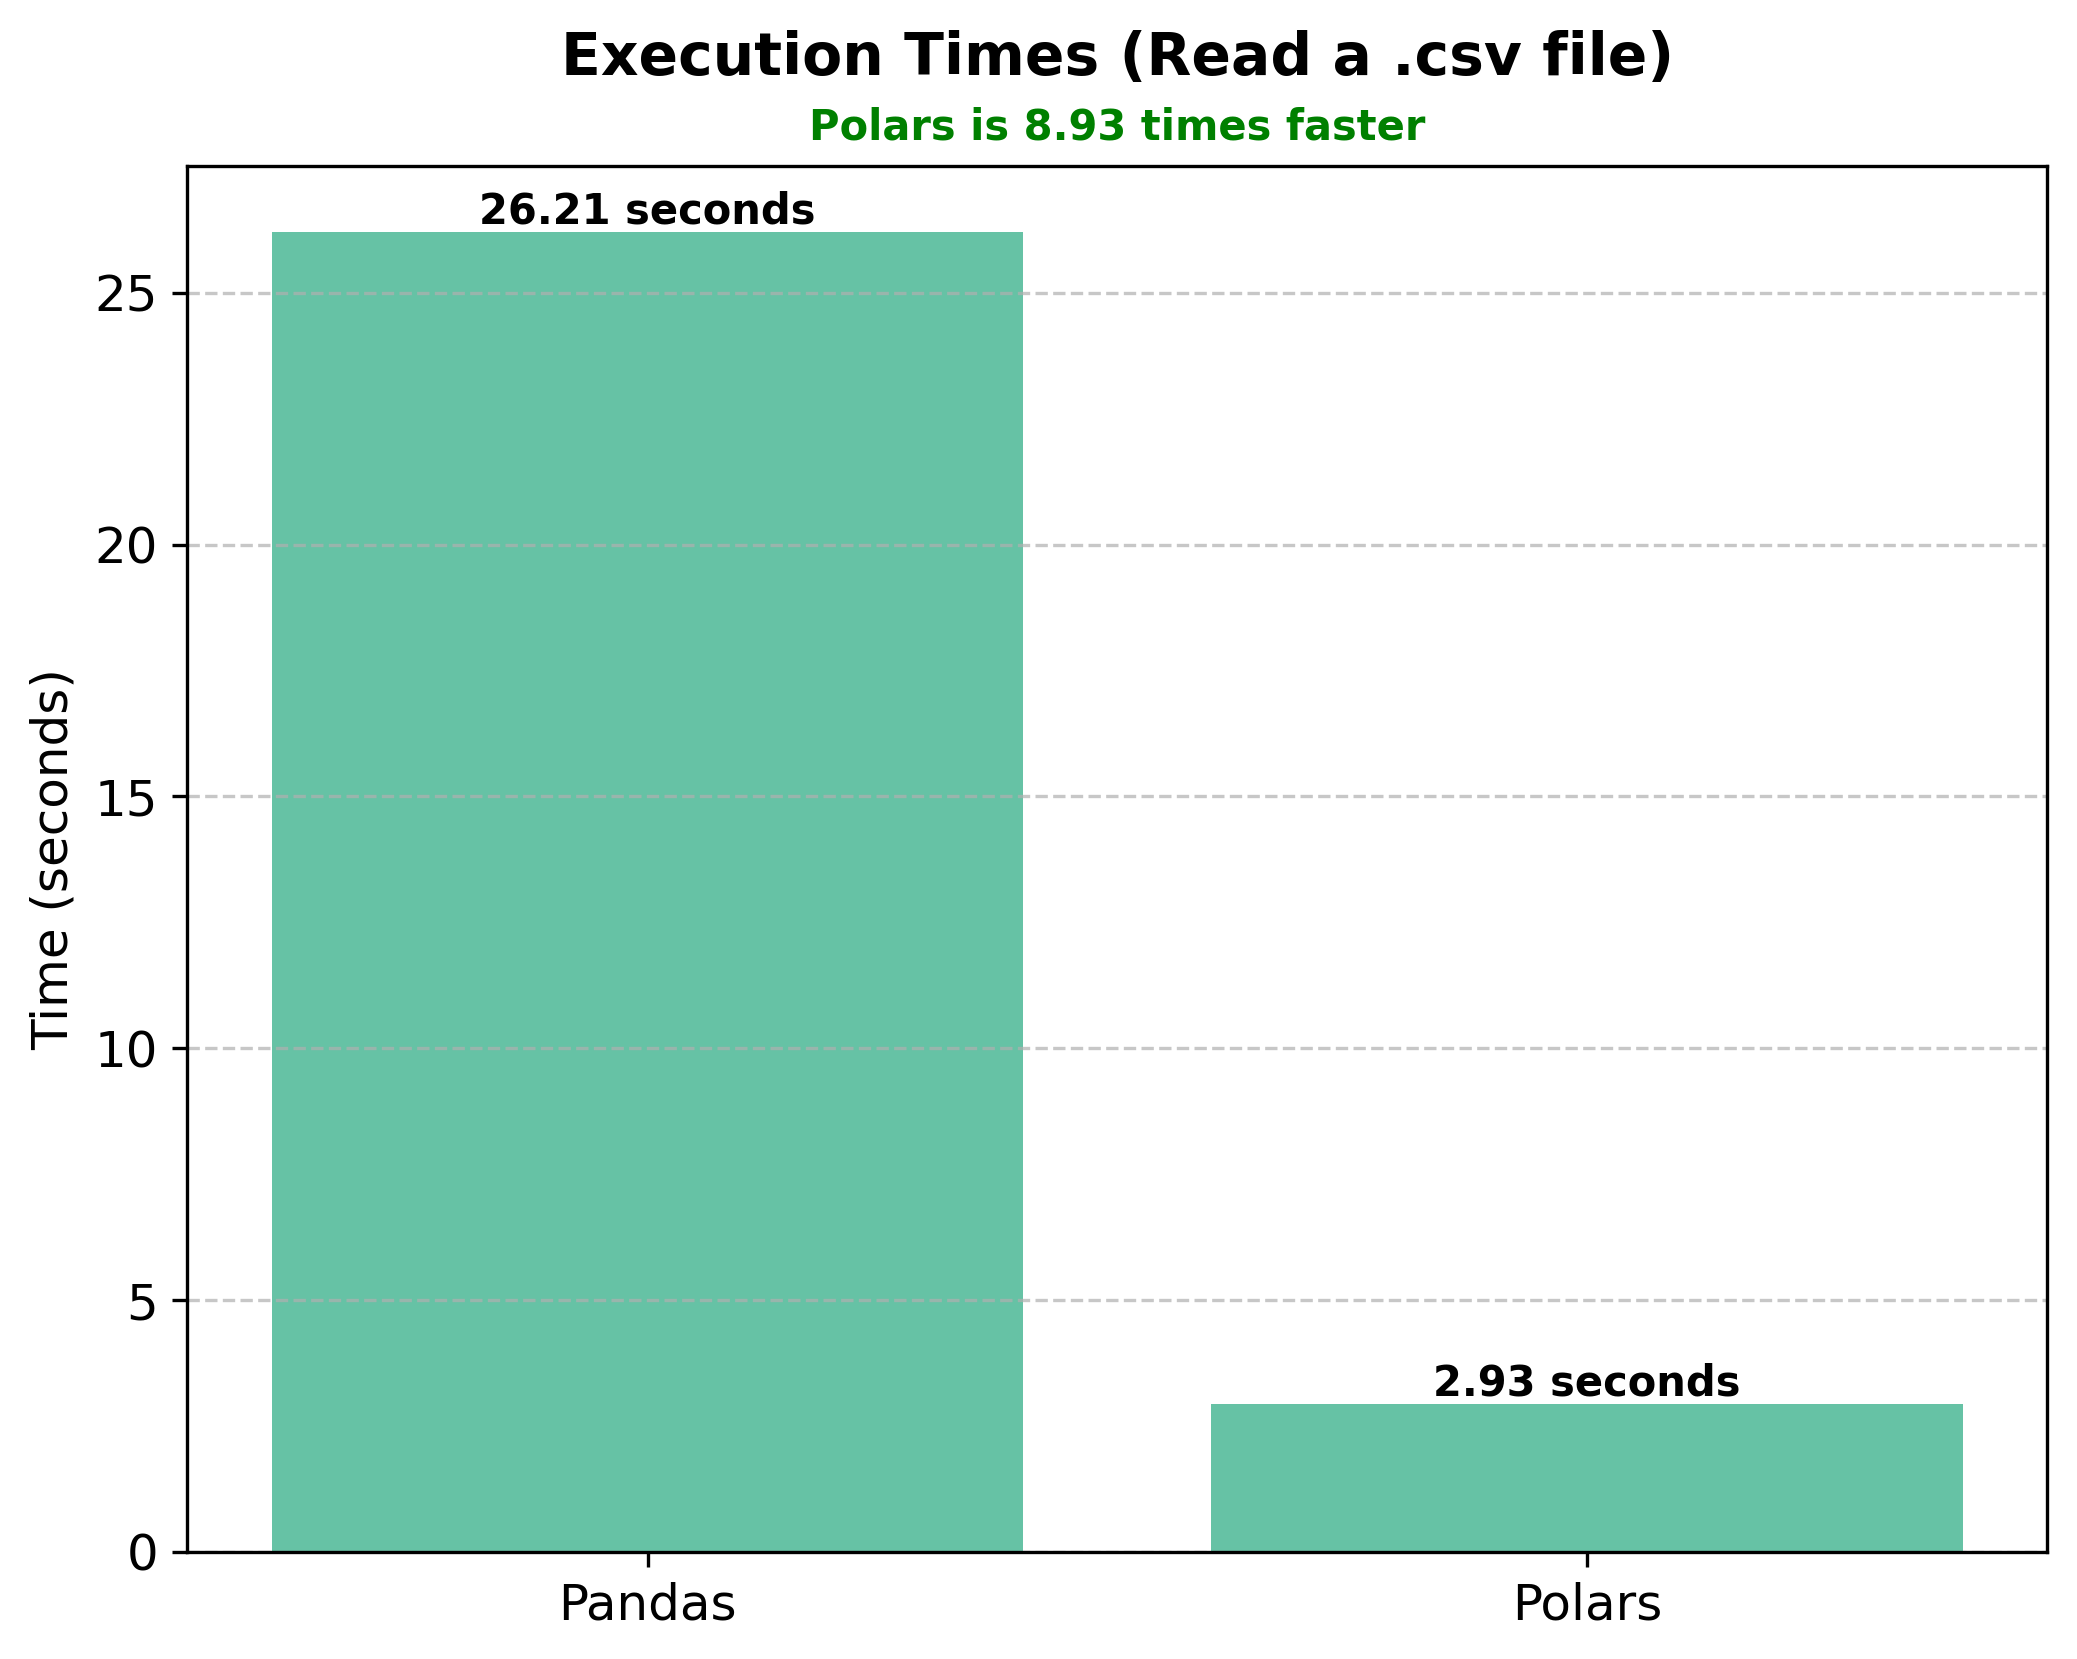

In [14]:
plot_times(time_taken_tot_1, time_taken_tot_2, "(Read a .csv file)")

In [15]:
time_taken_tot_1 = 0
for i in range(10):
    start_time = time.time()
    df_pd_filter = df_pd[df_pd["position"] == "attacker"]
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_1 += time_taken
time_taken_tot_1 /=10

In [16]:
time_taken_tot_2 = 0
for i in range(10):
    start_time = time.time()
    df_pl_filter = df_pl.filter(pl.col("position") == "attacker")
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_2 += time_taken
time_taken_tot_2 /=10

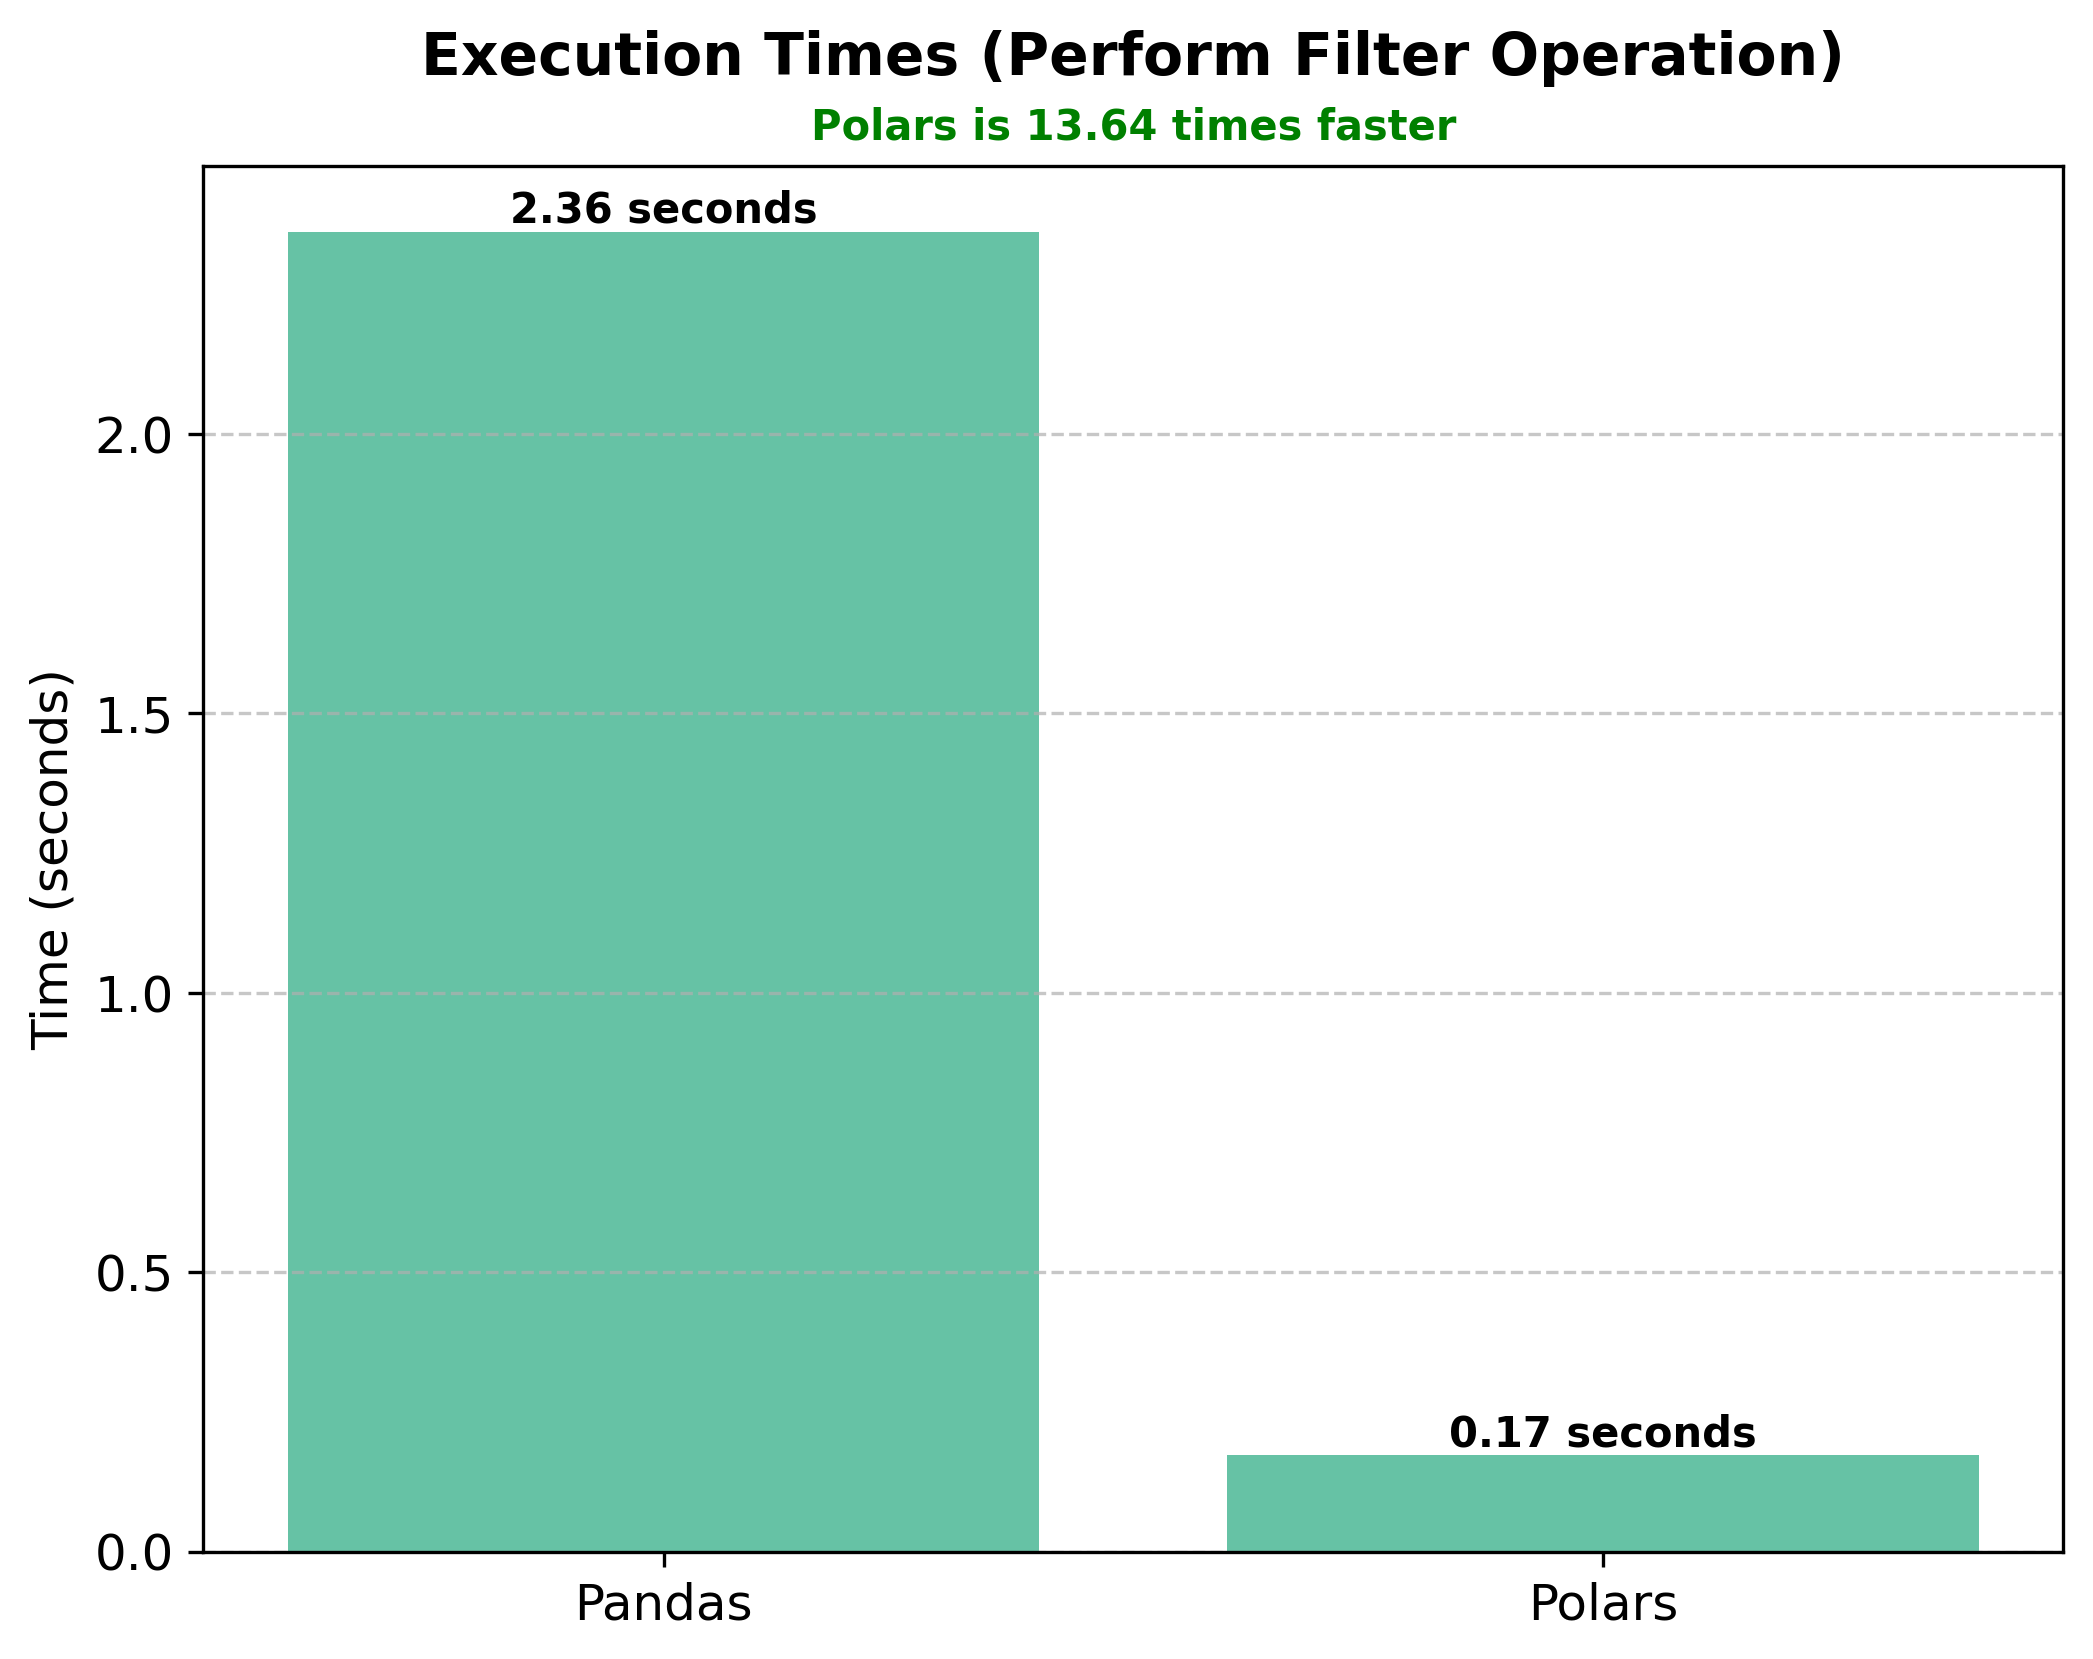

In [17]:
plot_times(time_taken_tot_1, time_taken_tot_2, "(Perform Filter Operation)")

In [18]:
time_taken_tot_1 = 0
for i in range(10):
    start_time = time.time()
    
    df_agg_pd = (df_pd
             .groupby([
                 df_pd["player_id"], 
                 df_pd["body_part"]
             ]
             )
             .agg(
                 total_goals = ("goal", "sum"),
                 total_xG = ("xG", "sum")
             )
             .reset_index()
             .sort_values(
                 by=["total_goals", "total_xG", "player_id", "body_part"], 
                 ascending=[False, False, True, True]
             )
    )
    
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_1 += time_taken
time_taken_tot_1 /=10

In [19]:
time_taken_tot_2 = 0
for i in range(10):
    start_time = time.time()
    
    df_agg_pl = (df_pl
             .group_by(
                 [
                     pl.col("player_id"), 
                     pl.col("body_part")
                 ]
             )
             .agg(
                 pl.sum("goal").alias("total_goals"), 
                 pl.sum("xG").alias("total_xG")
             )
             .sort(
                 by=["total_goals", "total_xG", "player_id", "body_part"], 
                 descending=[True, True, False, False]
             )
    )
    
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_2 += time_taken
time_taken_tot_2 /=10

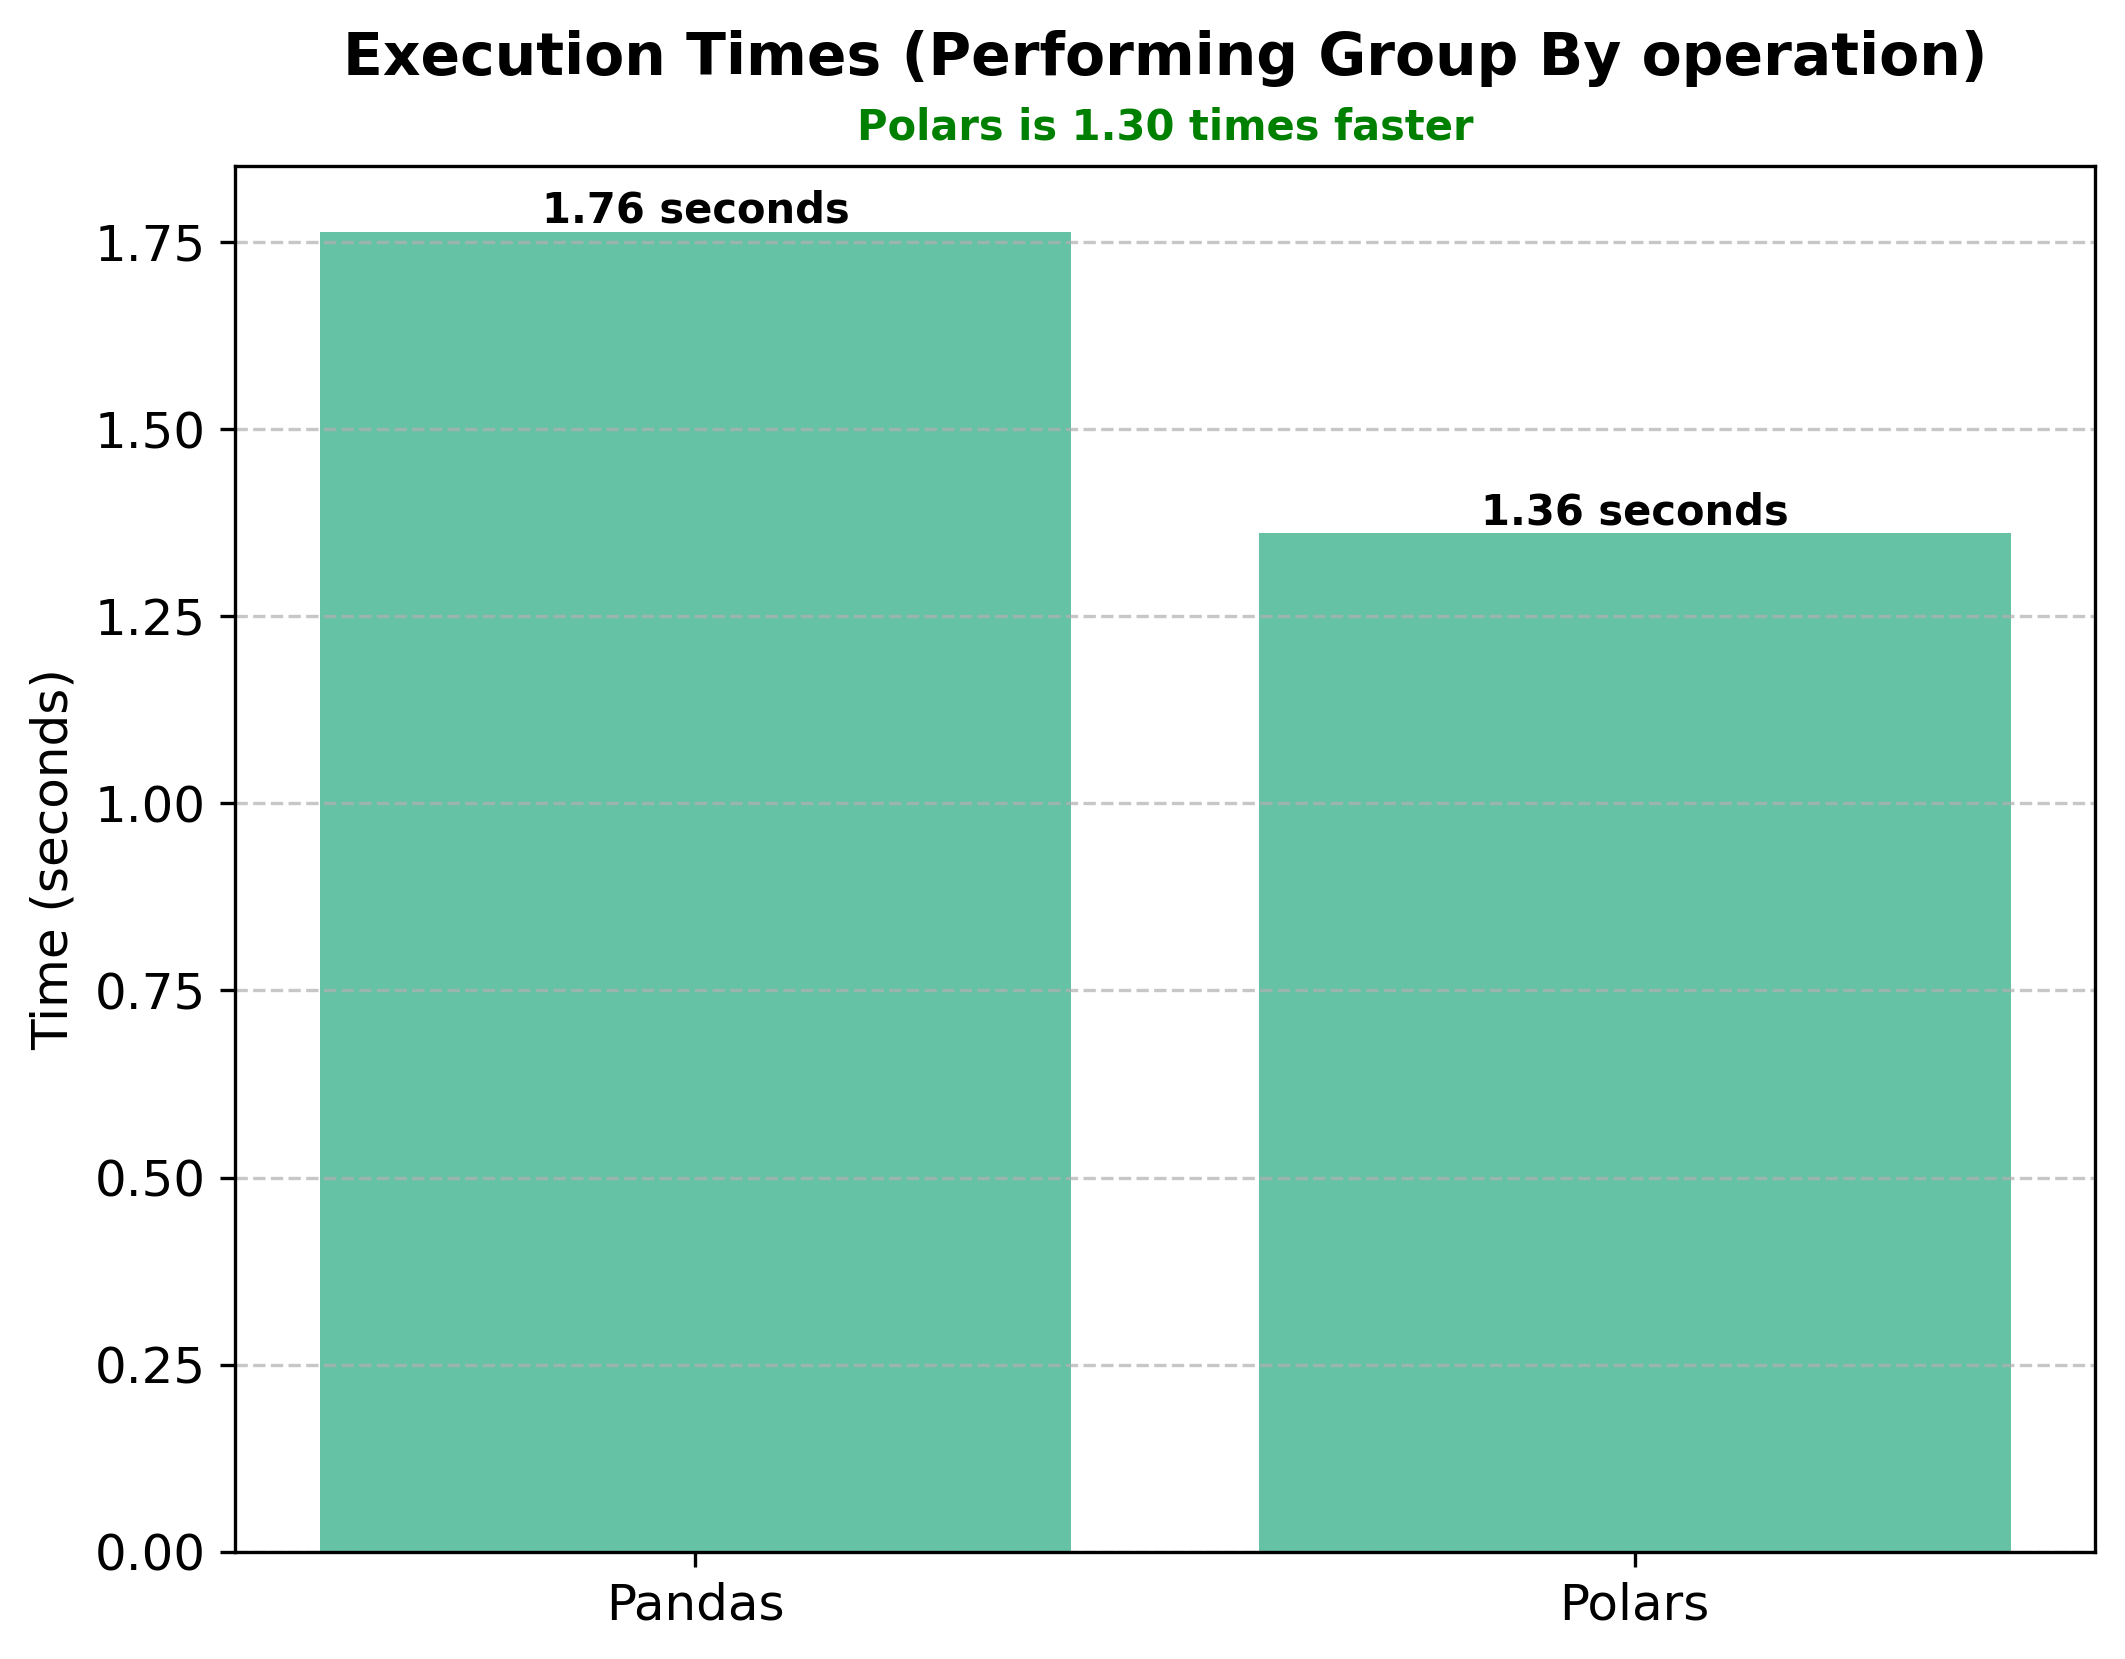

In [20]:
plot_times(time_taken_tot_1, time_taken_tot_2, "(Performing Group By operation)")

In [21]:
time_taken_tot_1 = 0
for i in range(10):
    start_time = time.time()
    df_pd = pd.read_csv("data.csv")
    df_pd = df_pd[df_pd["position"] == "attacker"]
    df_agg_pd = (
        df_pd
         .groupby([
             df_pd["player_id"], 
             df_pd["body_part"]
         ]
         )
         .agg(
             total_goals = ("goal", "sum"),
             total_xG = ("xG", "sum")
         )
         .reset_index()
         .sort_values(
             by=["total_goals", "total_xG", "player_id", "body_part"], 
             ascending=[False, False, True, True]
         )
    )
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_1 += time_taken
time_taken_tot_1 /=10

In [22]:
time_taken_tot_2 = 0
for i in range(10):
    start_time = time.time()
    df_agg_pl = (
        pl.read_csv("data.csv")
         .filter(pl.col("position") == "attacker")
         .group_by(
             [
                 pl.col("player_id"), 
                 pl.col("body_part")
             ]
         )
         .agg(
             pl.sum("goal").alias("total_goals"), 
             pl.sum("xG").alias("total_xG")
         )
         .sort(
             by=["total_goals", "total_xG", "player_id", "body_part"], 
             descending=[True, True, False, False]
         )
    )
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_2 += time_taken
time_taken_tot_2 /=10

In [23]:
time_taken_tot_3 = 0
for i in range(10):
    start_time = time.time()
    df_agg_pl = (
        pl.scan_csv("data.csv")
         .filter(pl.col("position") == "attacker")
         .group_by(
             [
                 pl.col("player_id"), 
                 pl.col("body_part")
             ]
         )
         .agg(
             pl.sum("goal").alias("total_goals"), 
             pl.sum("xG").alias("total_xG")
         )
         .sort(
             by=["total_goals", "total_xG", "player_id", "body_part"], 
             descending=[True, True, False, False]
         )
    )
    df_agg_pl = df_agg_pl.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_taken_tot_3 += time_taken
time_taken_tot_3 /=10

In [26]:
def plot_times_3(t1, t2, t3, title):
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6), dpi=300) 
    plt.bar(['Pandas', 'Polars', 'Lazy Polars'], [t1, t2, t3])
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(f'Execution Times {title}\n', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.text(0, t1, f'{t1:.2f} seconds', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(1, t2, f'{t2:.2f} seconds', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(2, t2, f'{t3:.2f} seconds', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ratio = t1 / t3
    plt.text(1, max(t1, t2) * 1.07, f'Polars Lazy is {ratio:.2f} times faster', ha='center', fontsize=10, fontweight='bold', color='green')

    plt.show()

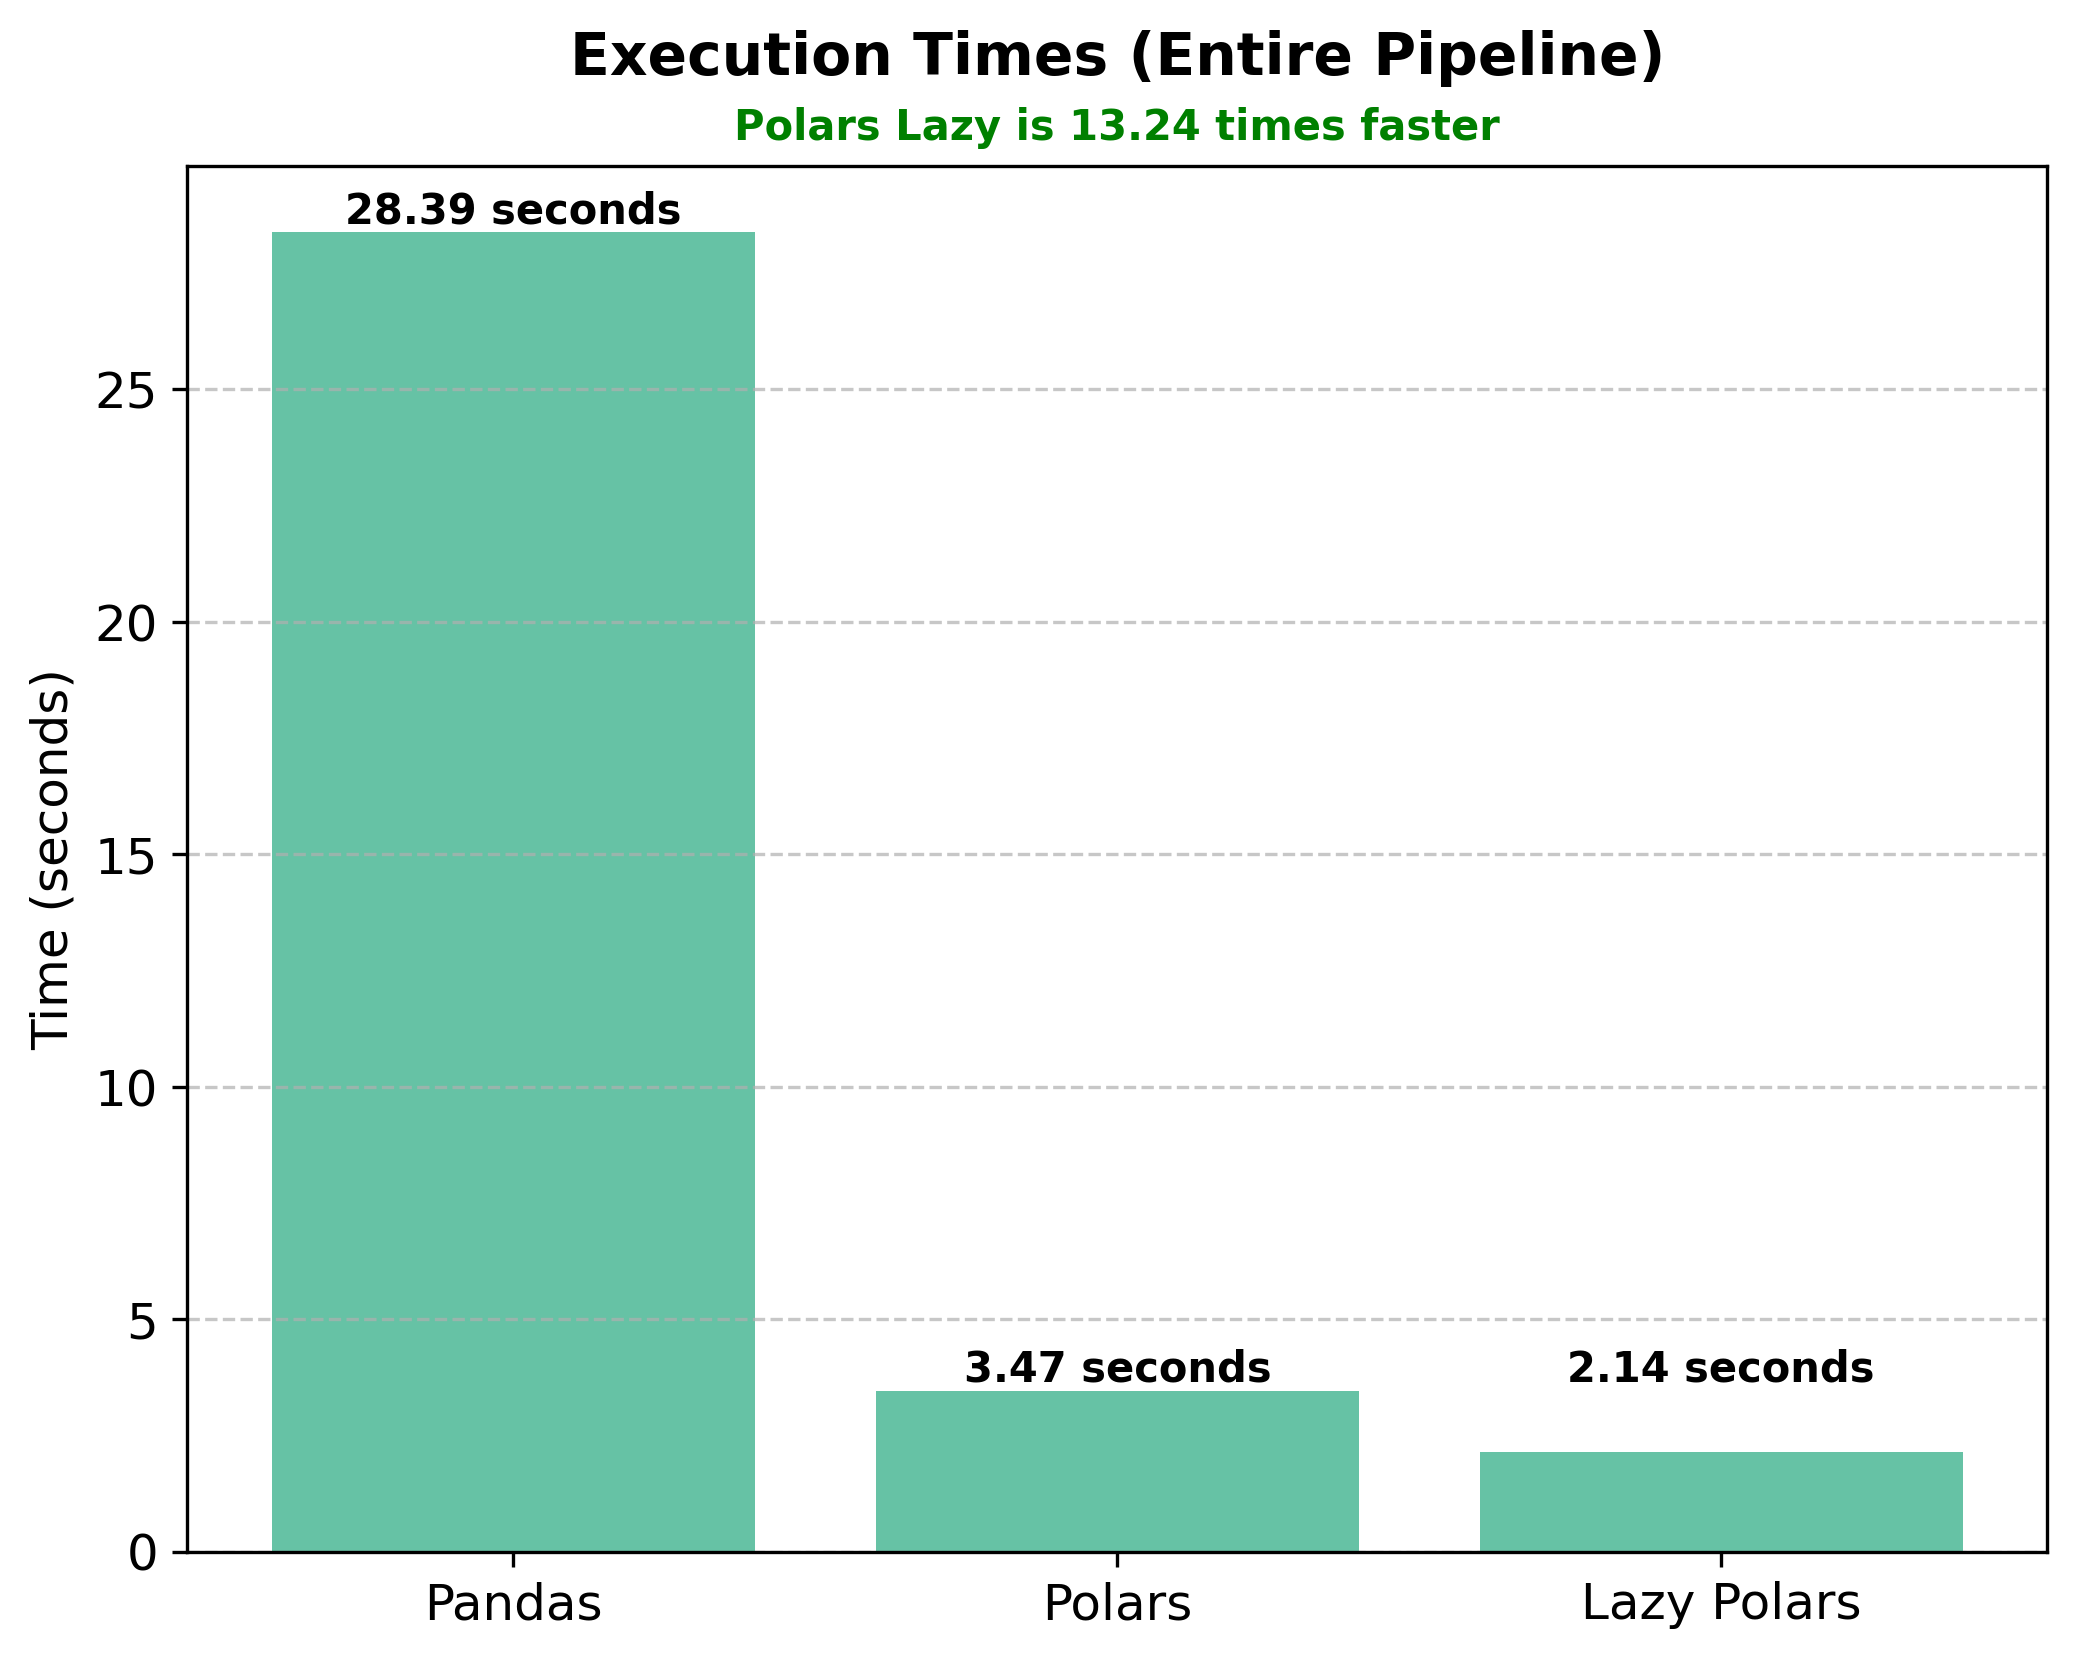

In [27]:
plot_times_3(time_taken_tot_1, time_taken_tot_2, time_taken_tot_3, "(Entire Pipeline)")

In [31]:
ctx = pl.SQLContext(population=df_pl, eager_execution=True)
query = """
    select player_id, body_part, sum(goal) as total_goals, sum(xG) as total_xG 
    from population
    group by player_id, body_part
    order by total_goals desc, total_xG desc, player_id, body_part
"""
print(ctx.execute(query))

shape: (2_000, 4)
┌───────────┬────────────┬─────────────┬─────────────┐
│ player_id ┆ body_part  ┆ total_goals ┆ total_xG    │
│ ---       ┆ ---        ┆ ---         ┆ ---         │
│ i64       ┆ str        ┆ i64         ┆ f64         │
╞═══════════╪════════════╪═════════════╪═════════════╡
│ 281       ┆ other      ┆ 628         ┆ 2571.509744 │
│ 307       ┆ other      ┆ 616         ┆ 2562.186383 │
│ 383       ┆ right_foot ┆ 615         ┆ 2545.094103 │
│ 325       ┆ other      ┆ 614         ┆ 2511.692592 │
│ 474       ┆ header     ┆ 613         ┆ 2513.789606 │
│ …         ┆ …          ┆ …           ┆ …           │
│ 472       ┆ left_foot  ┆ 487         ┆ 2427.774846 │
│ 330       ┆ right_foot ┆ 483         ┆ 2527.70016  │
│ 331       ┆ left_foot  ┆ 483         ┆ 2439.681554 │
│ 83        ┆ header     ┆ 475         ┆ 2514.361787 │
│ 273       ┆ header     ┆ 473         ┆ 2463.526044 │
└───────────┴────────────┴─────────────┴─────────────┘
